# Slippage Simulator

In [1]:
from uniswappy import *
import time
import datetime
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Setup 0x API

In [2]:
sell_token = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
buy_token = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
sell_amount = '10000000'

api = API0x(chain = Chain0x.ETHEREUM)
res = api.apply(sell_token, buy_token, sell_amount)

### Setup Uniswap Pool

In [3]:
prices = []

USER_NM = 'user0'
eth_amount = 1000
tkn_amount = eth_amount/float(res['price'])

eth = ERC20("ETH", "0x09")
tkn = ERC20("USDC", "0x111")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
lp.add_liquidity("user0", eth_amount, tkn_amount, eth_amount, tkn_amount)
lp.summary()

Exchange ETH-USDC (LP)
Reserves: ETH = 1000, USDC = 3118040.129236471
Liquidity: 55839.41376157589 



### Perform Mock Swap / Arbitrage

In [4]:
N = 20
tkn_price_arr = []
tstamp = []
MAX_SLEEP = 3

lp_tot_arr = []
x_amt_arr = []
y_amt_arr = []
lp_price_arr = []

swap_tstamp = []
swap_amts = []

market_tstamp = []
market_price = []
res = api.apply(sell_token, buy_token, sell_amount)
p = 1/float(res['price'])
correction = CorrectReserves(lp, x0 = p)

tdModel = TokenDeltaModel(30)

for k in range(N):
    
    remaining_sleep = MAX_SLEEP
    
    # RANDOM SWAP
    pause = random.uniform(0, remaining_sleep)
    time.sleep(pause) 
    rnd_amt = tdModel.delta()
    select_tkn = EventSelectionModel().bi_select(0.5)
    
    if(select_tkn == 0):
        out = Swap().apply(lp, eth, USER_NM, rnd_amt)  
    else:
        out = Swap().apply(lp, tkn, USER_NM, 0.5*p*rnd_amt) 
        
    swap_tstamp.append(datetime.datetime.now())
    swap_amts.append(rnd_amt)
    
    lp_price_arr.append(lp.get_price(correction.get_x_tkn()))  
    x_amt_arr.append(lp.get_reserve(correction.get_y_tkn()))  
    y_amt_arr.append(lp.get_reserve(correction.get_x_tkn()))                  
    tstamp.append(datetime.datetime.now())  
    remaining_sleep -= pause
    print(f"time-trade {datetime.datetime.now()}")    
    
    # MARKET ARBITRAGE
    pause = random.uniform(0, remaining_sleep)
    time.sleep(pause)     
    res = api.apply(sell_token, buy_token, sell_amount)
    p = 1/float(res['price'])
    
    market_tstamp.append(datetime.datetime.now())
    market_price.append(p)
    correction.apply(p)
                
    lp_price_arr.append(lp.get_price(correction.get_x_tkn()))  
    x_amt_arr.append(lp.get_reserve(correction.get_y_tkn()))  
    y_amt_arr.append(lp.get_reserve(correction.get_x_tkn()))                  
    tstamp.append(datetime.datetime.now())
    remaining_sleep -= pause
    print(f"time-arbitrage {datetime.datetime.now()}")           
                
    time.sleep(remaining_sleep) 


time-trade 2024-02-25 15:14:09.892641
time-arbitrage 2024-02-25 15:14:11.358872
time-trade 2024-02-25 15:14:13.891869
time-arbitrage 2024-02-25 15:14:15.370527
time-trade 2024-02-25 15:14:16.489209
time-arbitrage 2024-02-25 15:14:17.224518
time-trade 2024-02-25 15:14:18.975434
time-arbitrage 2024-02-25 15:14:20.639713
time-trade 2024-02-25 15:14:23.861464
time-arbitrage 2024-02-25 15:14:26.094044
time-trade 2024-02-25 15:14:27.358153
time-arbitrage 2024-02-25 15:14:29.784633
time-trade 2024-02-25 15:14:30.675297
time-arbitrage 2024-02-25 15:14:33.258316
time-trade 2024-02-25 15:14:35.370572
time-arbitrage 2024-02-25 15:14:37.235195
time-trade 2024-02-25 15:14:38.305209
time-arbitrage 2024-02-25 15:14:39.498311
time-trade 2024-02-25 15:14:41.236932
time-arbitrage 2024-02-25 15:14:44.041191
time-trade 2024-02-25 15:14:45.160899
time-arbitrage 2024-02-25 15:14:47.092550
time-trade 2024-02-25 15:14:49.799823
time-arbitrage 2024-02-25 15:14:51.588970
time-trade 2024-02-25 15:14:54.587208
ti

### Plot Uniswap Liquidity Pool States

Text(0, 0.5, 'Swap Amounts (ETH)')

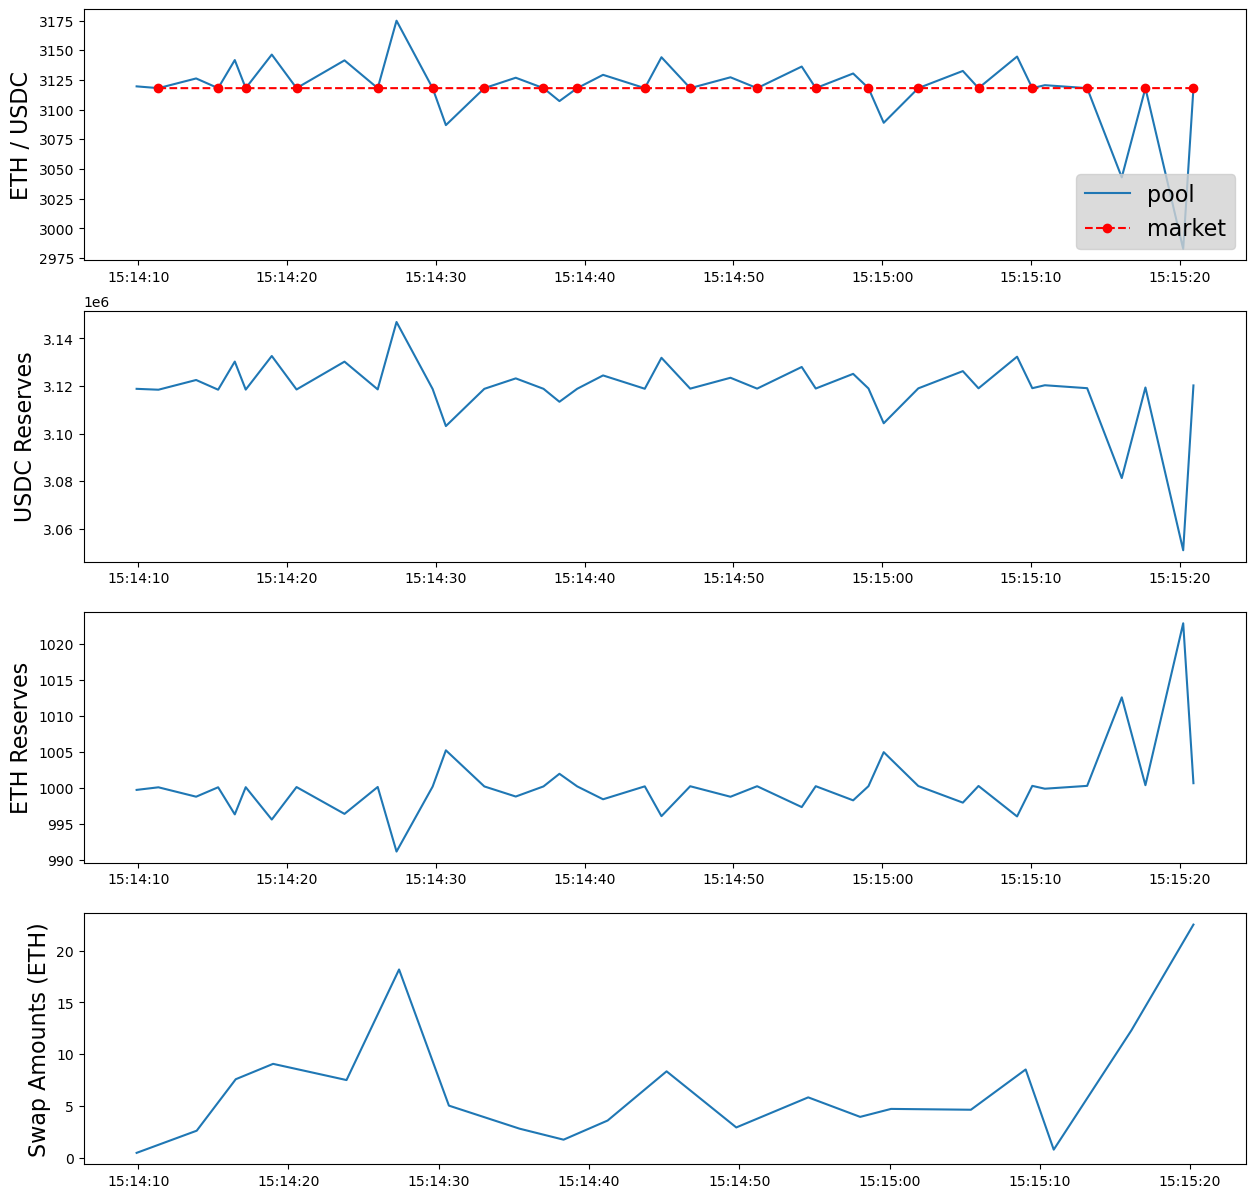

In [5]:
fig, (p_ax, tkn1_ax, tkn2_ax, s_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(15, 15))
p_ax.plot(tstamp, lp_price_arr, label='pool')
p_ax.plot(market_tstamp, market_price, 'ro--', label='market')
p_ax.set_ylabel(f'{eth.token_name} / {tkn.token_name}', fontsize=16)
p_ax.legend(fontsize=16, facecolor="lightgray", loc='lower right')

tkn1_ax.plot(tstamp, x_amt_arr)
tkn1_ax.set_ylabel(f'{tkn.token_name} Reserves', fontsize=16)

tkn2_ax.plot(tstamp, y_amt_arr)
tkn2_ax.set_ylabel(f'{eth.token_name} Reserves', fontsize=16)

s_ax.plot(swap_tstamp, swap_amts)
s_ax.set_ylabel(f'Swap Amounts ({eth.token_name})', fontsize=16)

### Plot Swap Model

Text(0.5, 0, 'ETH Swap Amount')

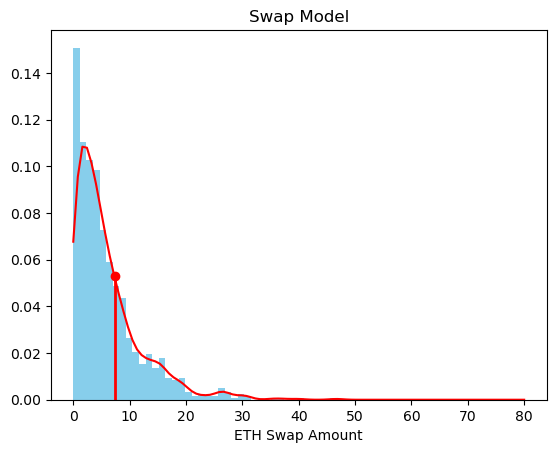

In [6]:
r_vals = [tdModel.delta() for k in range(1000)] 
dens = sm.nonparametric.KDEUnivariate(r_vals)
dens.fit()

x = np.linspace(0,80,100)
y = dens.evaluate(x)

#rsamp = tdModel.delta()
rind = random.randint(0, len(dens.icdf))
rsamp = dens.icdf[rind]

residuals = np.abs(x - rsamp)
ind = np.argmin(residuals, axis=0) 

plt.hist(r_vals, density=True, bins=40, color='skyblue')
plt.plot(x, y, 'r')
plt.plot([rsamp,rsamp], [0,y[ind]], 'r', linewidth=2)
plt.plot(rsamp,y[ind],'ro') 
plt.title(f'Swap Model') 
plt.xlabel(f'{eth.token_name} Swap Amount') 